# Building a image classification NN with PyTorch Lightning

# Building blocks for our problem

## Visualising our data 

When classifying images we need to understand what kind of data we inputting into the model.
1. An colour image is made up of 3 colour channels: red, green and blue (RGB), we use a built in command to convert the image to an array of values for each
2. Our images have mostly similar size but we will crop in the center to get them all the same size (224 x 224)

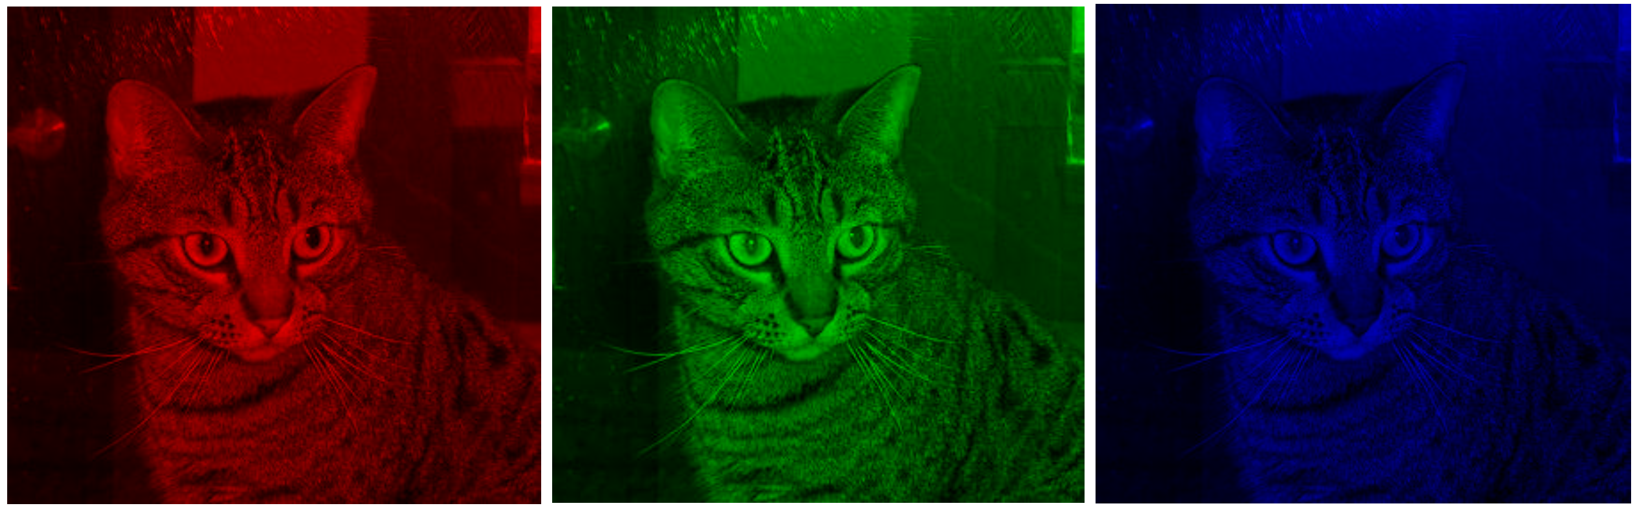

We can then load our presorted training, validation and test set labelled as 'cat' or 'dog' with our transformations

If you're wondering what the validation set is, it's just a small subset of our images we use to check our algorithm is working properly!

We then use a dataloader which randomly slices up our data into minibatches and allows us to easily select our data for our train ,validation and test set.

## Building the model

We are going to develop a simple deep learning with 2 fully connected linear layers.

### Your 2 linear layers

* Our input has 224 x 224 x 3 features (in_features) representing each pixel of the 3 colour channels, so in_features for the first layer will also be 224 x 224 x 3.
* We have chosen our second layer to have 128 nodes. This was arbritary in this case but we sometimes look to known architectures to choose this
* NOTE: out_features for the previous layer are the in_features for the next layer
* out_features for the last layer is the number of classes we have, in this case 2

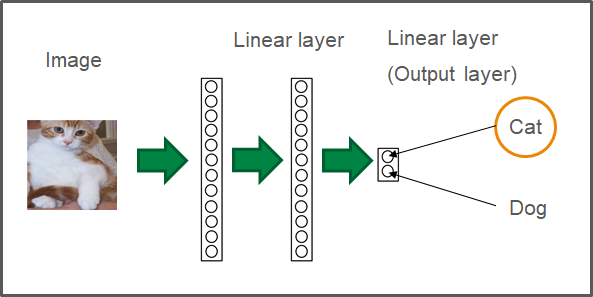

### Activation functions

After the first layer, we pass the output through a relu function which looks like this:

The negative values in our weight array are assigned 0

\begin{equation}
f(x) = 
    \begin{cases}
      0 & \text{if $x$ < 0}\\
      x & \text{if $x$ >= 0}\\
    \end{cases}       
\end{equation}

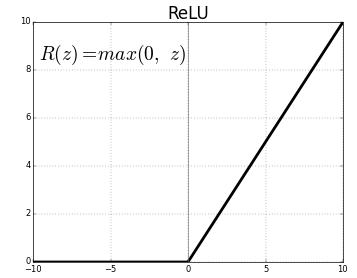

For example: relu([-3,3]) = [0,3]

The second layer passes to a softmax layer which determines which is more likely: is the picture a cat or a dog?

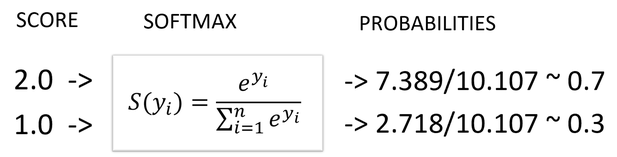

## Training the model

### Compute the loss

* Also known as a cost function - cross_entropy is just one loss function, there are others
* It's a method of evaluating how well specific algorithm models the given data.
* With the help of some optimization function, the loss function will decrease to get our predictions closer to the true value

### Define an optimiser

We then would normally need backprop and an optimiser such as gradient descent but backprop is implemented for us in pytorch so we just need to define an optimiser, in this case ADAM, a version of gradient descent.

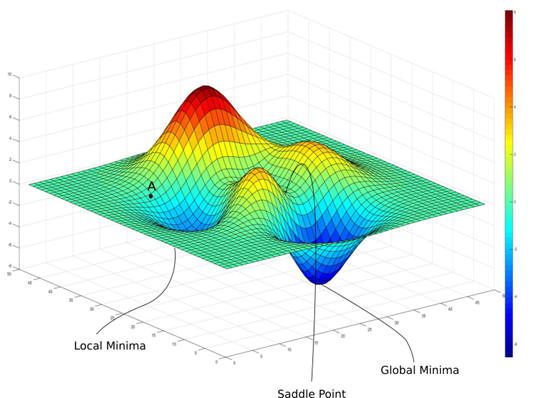

## Full Process

In [2]:
import pytorch_lightning as pl #the library we are using to speed up training
import os
import numpy as np
import torch #main pytorch library
import torchvision #pytorch library for dealing with images
from torch.nn import functional as F #set of methods for operating on our layers
from torch.utils.data import DataLoader #Loads our image data into our model
from torchvision import transforms #image transformations
import tensorboard #used for visualisation

In [11]:
class catdogClassifier(pl.LightningModule):
    
    #PREPARING OUR DATA
    
    def prepare_data(self):
        #2 transforms, one crop in the center to make all the images the same size and one that converts it to RGB pixel values
        transform = transforms.Compose([transforms.CenterCrop(size = (224,224)),transforms.ToTensor()])
        self.train_set = torchvision.datasets.ImageFolder("cat_dog_ex/train", transform=transform)
        self.val_set = torchvision.datasets.ImageFolder("cat_dog_ex/val", transform=transform)
        self.test_set = torchvision.datasets.ImageFolder("cat_dog_ex/test", transform=transform)

    #Dataloaders just split the train, test and validation sets for us!
    def train_dataloader(self):
        train_loader=DataLoader(self.train_set, batch_size = 32, shuffle = True)
        return train_loader
        
    def val_dataloader(self):
        val_loader=DataLoader(self.val_set, batch_size = 32, shuffle = True)
        return val_loader

    def test_dataloader(self):
        test_loader=DataLoader(self.test_set, batch_size = 32, shuffle = True)
        return test_loader
    

    #DEFINING OUR LAYERS
    def __init__(self):
        super(catdogClassifier, self).__init__()
        # not the best model...
        #We have 2 layers
        self.l1 = torch.nn.Linear(224*224*3, 128)
        self.l2 = torch.nn.Linear(128,2)
        
    #DEFINING OUR FORWARD PROPAGATION STEP

    def forward(self, x):
        
        # called with self(x)
        
        #view arranges the data in a flat array
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.l1(x))
        
        x = self.l2(x)
        
        x = F.softmax(x,dim=1)
        
        return(x)
    
    #FORWARD PROP AND LOSS FUNCTION
    def training_step(self, batch, batch_nb):
        x, y = batch
        
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    #TEST STEPS
    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        return {'test_loss': F.cross_entropy(y_hat, y)}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}
        return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs}
    
    # OPTIMISER
    def configure_optimizers(self):   
        return torch.optim.Adam(self.parameters(), lr=0.01)
    
    #LOSS FUNCTION
    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)
    
    #VALIDATION STEPS      
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        return {'val_loss': loss}

    def validation_epoch_end(self, outputs):
        # called at the end of the validation epoch
        # outputs is an array with what you returned in validation_step for each batch
        #outputs = [{'loss': batch_0_loss}, {'loss': batch_1_loss}, ..., {'loss': batch_n_loss}] 
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}
    


In [14]:
#Define an instance of our model (all the stuff above)
catdogmodel = catdogClassifier()

# TRAINING -we will go through the data x times where x is the number of epochs
trainer=pl.Trainer(max_epochs=10,val_check_interval=2)    
trainer.fit(catdogmodel)
#Let's see how well we do on our test_set
trainer.test()

----------------------------------------------------------------------------------------------------
TEST RESULTS
{'test_loss': tensor(0.8267)}
----------------------------------------------------------------------------------------------------



In [13]:
#LOGGING EXTENSION -- let's see a graph
%load_ext tensorboard
%tensorboard --logdir lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 8816), started 4:44:28 ago. (Use '!kill 8816' to kill it.)